<a href="https://colab.research.google.com/github/sruthisamra/samra/blob/master/Copy_of_Emotions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import re
import gdown

google_drive_link = "https://drive.google.com/file/d/12iVo49pHF7T_tiQRzcF_PDAYCN1rcLLi/view?usp=drive_link"
file_id = re.search(r"/d/(\w+)/", google_drive_link).group(1)

# Define the output file name
output_file = 'fer2013.csv'

# Download the file
gdown.download(f'https://drive.google.com/uc?id={file_id}', output_file, quiet=False)

# Load the dataset into a Pandas DataFrame
data = pd.read_csv(output_file)

Downloading...
From: https://drive.google.com/uc?id=12iVo49pHF7T_tiQRzcF_PDAYCN1rcLLi
To: /content/fer2013.csv
100%|██████████| 301M/301M [00:06<00:00, 50.2MB/s]


### Data Processing

**Data Infromation**

In [ ]:
data.head()

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   Usage    35887 non-null  object
 2   pixels   35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [ ]:
data['Usage'].value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

**Data Preparetion**

emotions dictionary, which maps numerical labels to their corresponding emotional categories

In [ ]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

This function is to transform raw pixel data and labels into a format suitable for machine learning tasks, making it easier to train and evaluate models for emotion detection.
    
    
    Prepare data for modeling.
    
    Args:
        data: Data frame with labels and pixel data.
        
    Returns:
        image_array: Array of images.
        image_label: Array of image labels.
    

In [ ]:
import numpy as np

def prepare_data(data):

    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image

    return image_array, image_label

In [ ]:
train_image_array, train_image_label = prepare_data(data[data['Usage']=='Training'])
val_image_array, val_image_label = prepare_data(data[data['Usage']=='PrivateTest'])
test_image_array, test_image_label = prepare_data(data[data['Usage']=='PublicTest'])

Reshape and scale the images

In [ ]:
# Reshaping the Image Arrays
train_images = train_image_array.reshape((train_image_array.shape[0], 48, 48, 1))
val_images = val_image_array.reshape((val_image_array.shape[0], 48, 48, 1))
test_images = test_image_array.reshape((test_image_array.shape[0], 48, 48, 1))

# Data Type Conversion and Normalization
# Convert pixel values to floating-point numbers and normalize them
train_images = train_images.astype('float32') / 255
val_images = val_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

one-hot encode the emotion labels

In [ ]:
from keras.utils import to_categorical

# One-hot encode the labels
train_labels = to_categorical(train_image_label, num_classes=7)
val_labels = to_categorical(val_image_label, num_classes=7)
test_labels = to_categorical(test_image_label, num_classes=7)

In [ ]:
# Calculate class weights for handling imbalanced data in the training dataset.

class_weight = dict(
    zip(
        range(0, 7),  # Emotion labels range from 0 to 6
        (((data[data['Usage']=='Training']['emotion'].value_counts()).sort_index()) /
        len(data[data['Usage']=='Training']['emotion'])).tolist()
    )
)

print(class_weight)

**Data Visualization**

Visualize sample images for each of the seven emotions in the dataset

In [ ]:
import matplotlib.pyplot as plt

def plot_all_emotions():
    # Create a subplot with 1 row and 7 columns, defining the layout of the plot
    fig, axs = plt.subplots(1, 7, figsize=(30, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)  # Adjust spacing between subplots
    axs = axs.ravel()  # Flatten the array for easier iteration

    for i in range(7):
        # Find the index of the first image with the corresponding emotion label (i)
        idx = data[data['emotion'] == i].index[0]

        # Display the image
        axs[i].imshow(train_images[idx][:, :, 0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])  # Set the title as the emotion name
        axs[i].set_xticklabels([])  # Hide x-axis labels
        axs[i].set_yticklabels([])  # Hide y-axis labels

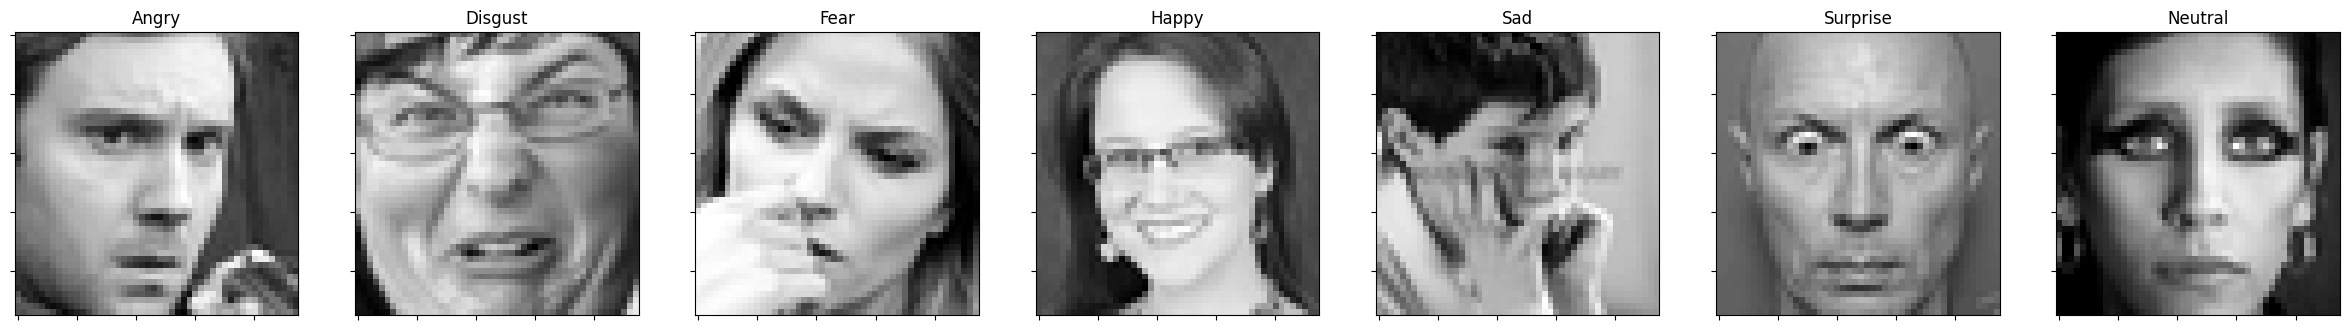

In [ ]:
plot_all_emotions()

Visualize example images for a specific emotion label (0-6)


    Plot example images for a specified emotion label.

    Parameters:
    - emotion_label: The emotion label (0-6) for which to display example images.

    The function displays five example images corresponding to the specified emotion label.


In [ ]:
def plot_emotion(emotion_label=0):

    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace=.2, wspace=.2)  # Adjust spacing between subplots
    axs = axs.ravel()  # Flatten the array for easier iteration

    for i in range(5):
        # Find the index of the ith image with the specified emotion label
        idx = data[data['emotion'] == emotion_label].index[i]

        # Display the image
        axs[i].imshow(train_images[idx][:, :, 0], cmap='gray')
        axs[i].set_title(emotions[train_labels[idx].argmax()])  # Set the title as the emotion name
        axs[i].set_xticklabels([])  # Hide x-axis labels
        axs[i].set_yticklabels([])  # Hide y-axis labels

Angry

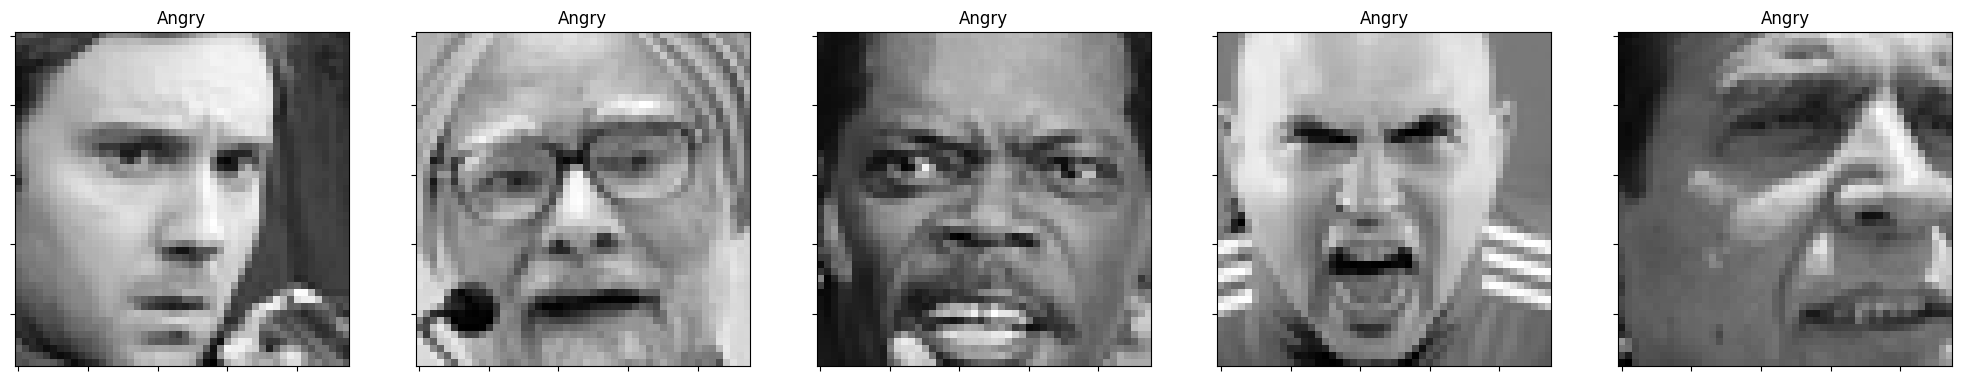

In [ ]:
plot_emotion(emotion_label=0)

Disgust

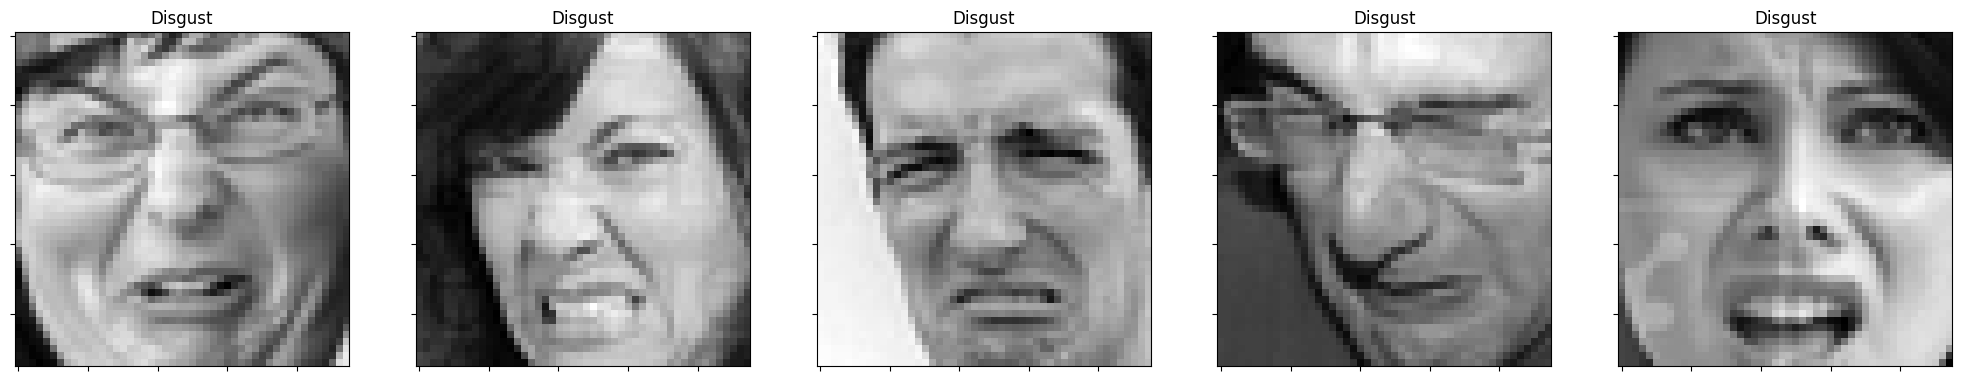

In [ ]:
plot_emotion(emotion_label=1)

Fear

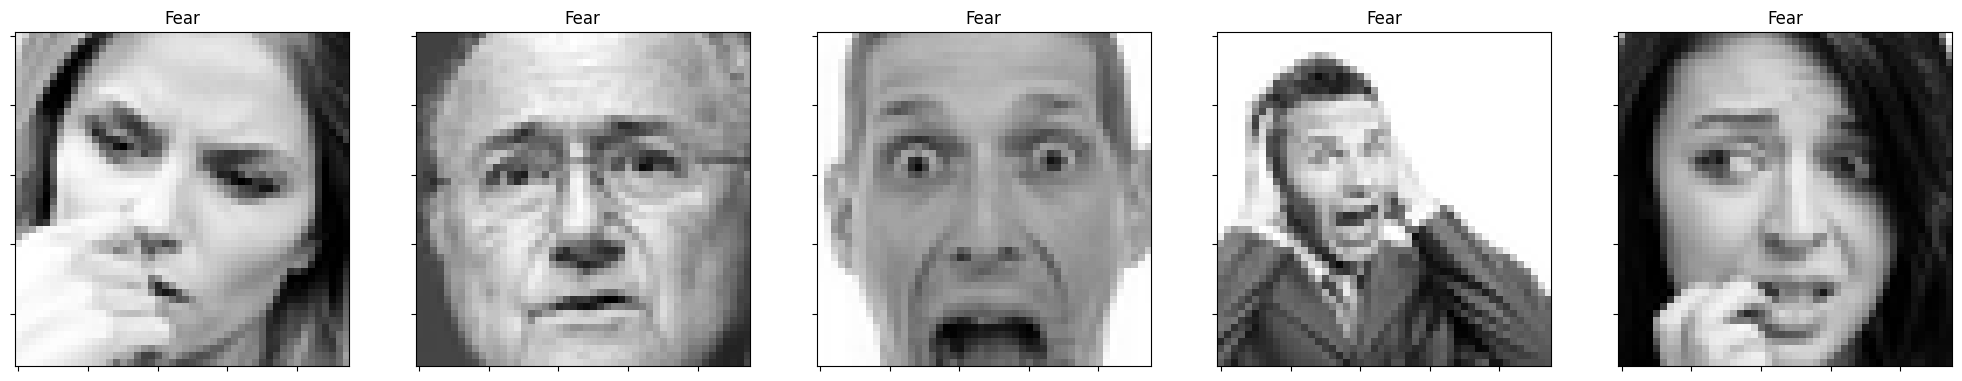

In [ ]:
plot_emotion(emotion_label=2)

Happy

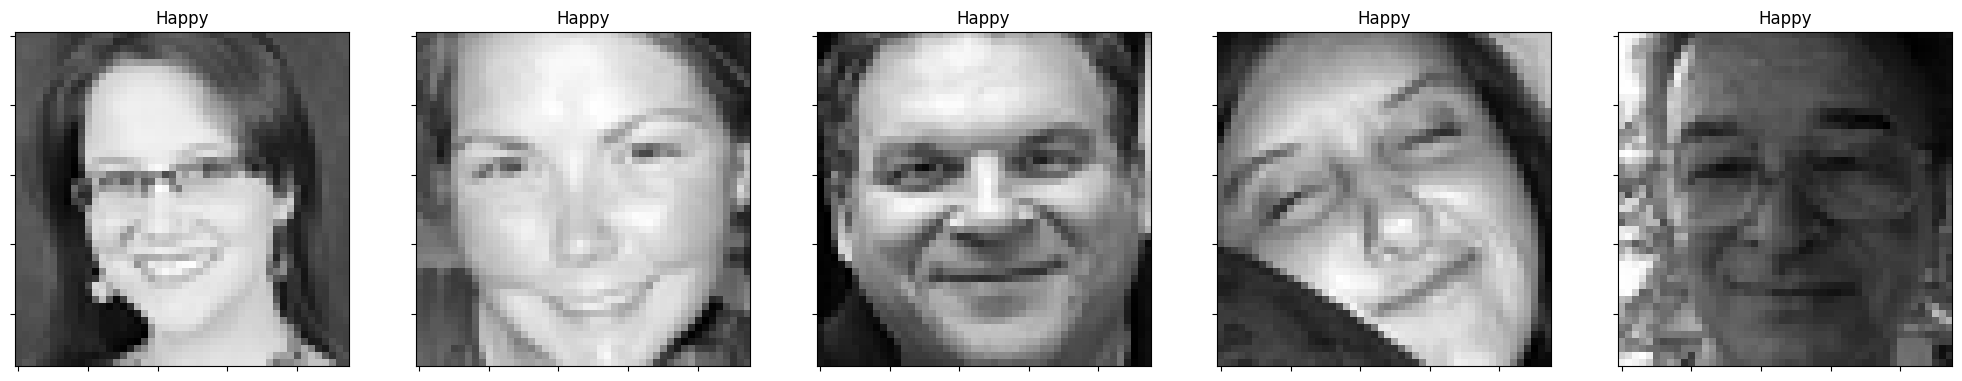

In [ ]:
plot_emotion(emotion_label=3)

Sad

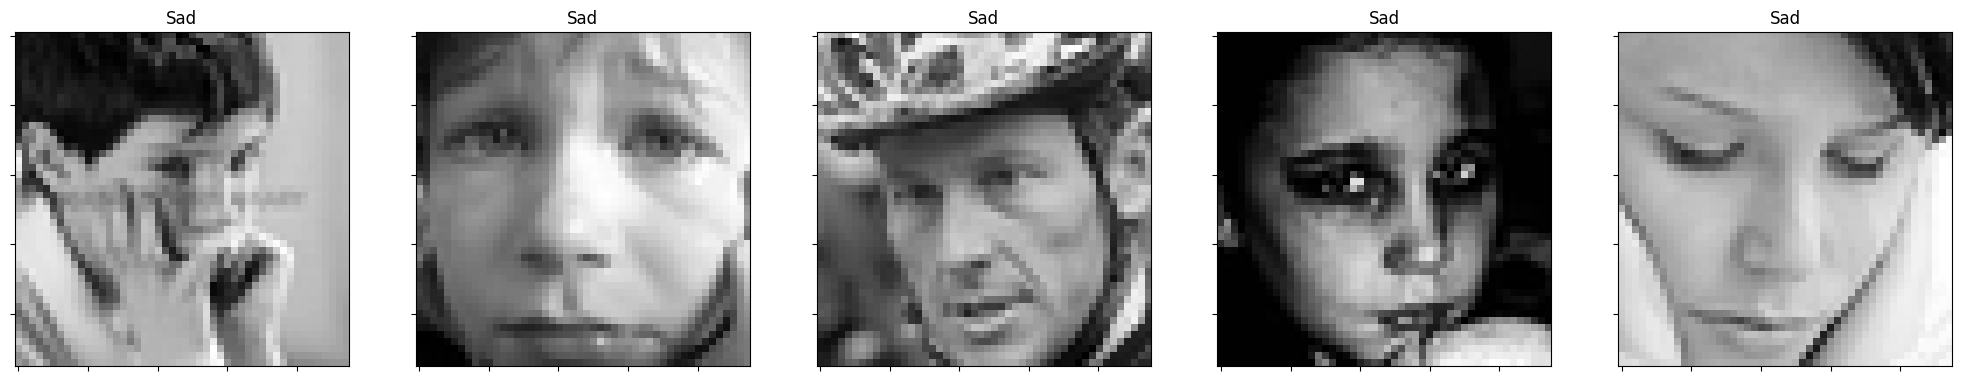

In [ ]:
plot_emotion(emotion_label=4)

Surprise

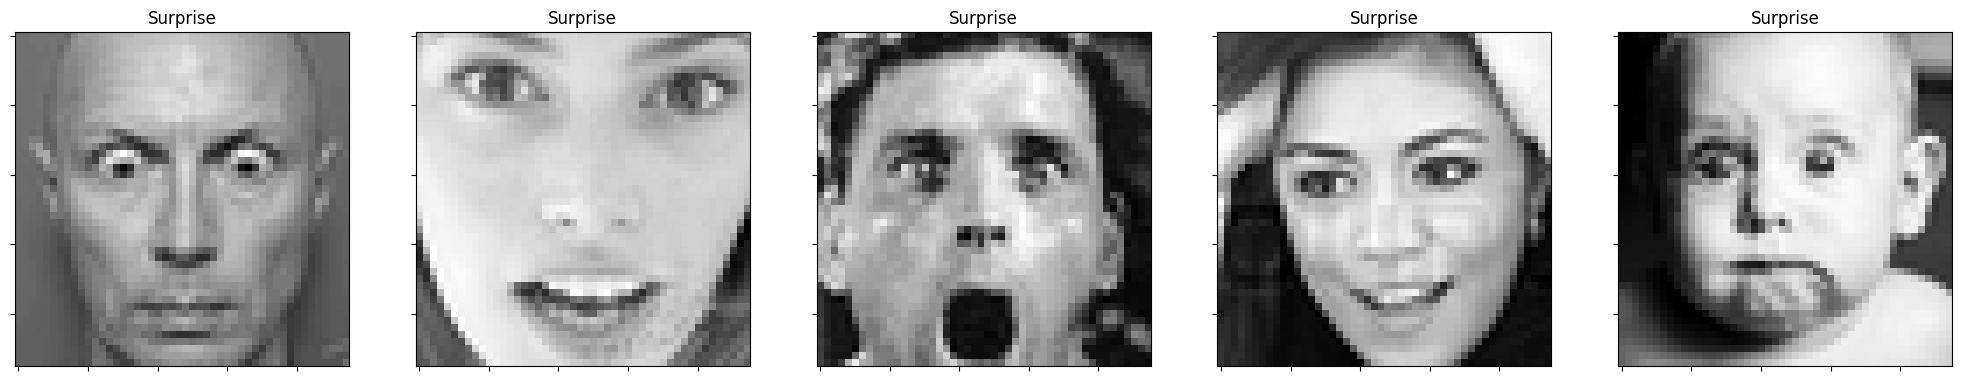

In [ ]:
plot_emotion(emotion_label=5)

Neutral

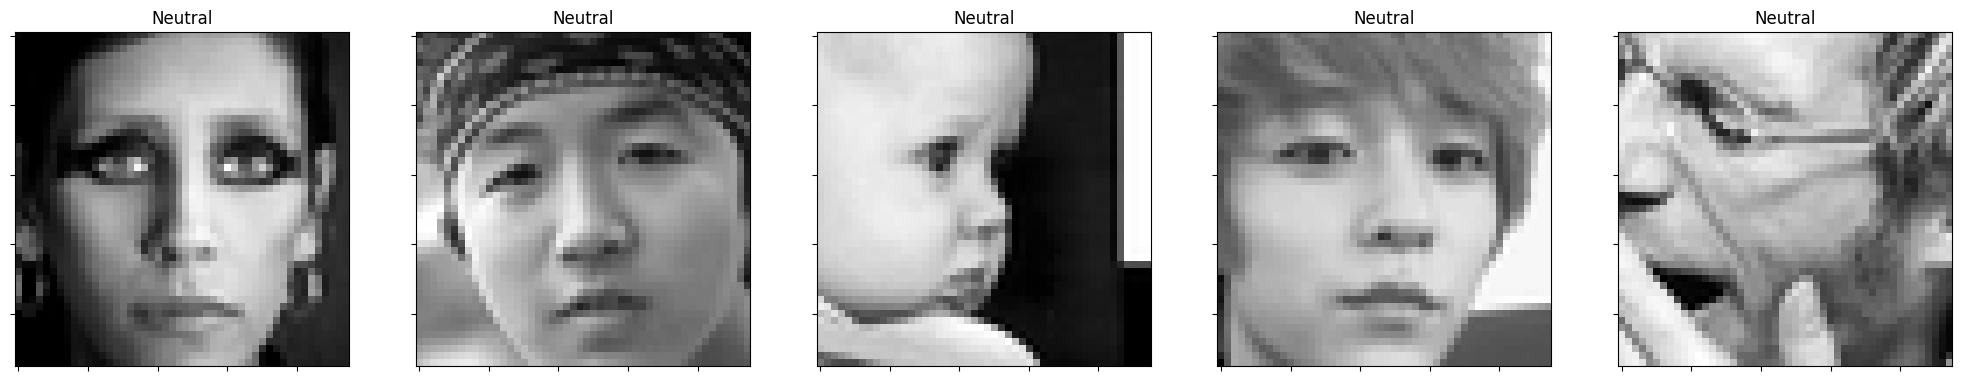

In [ ]:
plot_emotion(emotion_label=6)

Compare and plot the distributions of emotion labels in multiple datasets.

    Parameters:
    - arrays: A list of datasets with one-hot encoded emotion labels.
    - colors: A list of colors for the plots.
    - titles: A list of titles for each dataset's distribution plot.



In [ ]:
import random

def plot_distributions(arrays, colors, titles):

    fig, axs = plt.subplots(1, len(arrays), figsize=(6 * len(arrays), 6), sharey=False)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    axs = axs.ravel()
    x = emotions.values()

    for i, array in enumerate(arrays):
        df_array = pd.DataFrame()
        df_array['emotion'] = array.argmax(axis=1)
        y = df_array['emotion'].value_counts()
        keys_missed = list(set(emotions.keys()).difference(set(y.keys())))
        for key_missed in keys_missed:
            y[key_missed] = 0
        axs[i].bar(x, y.sort_index(), color=colors[i])
        axs[i].set_title(titles[i])
        axs[i].grid()

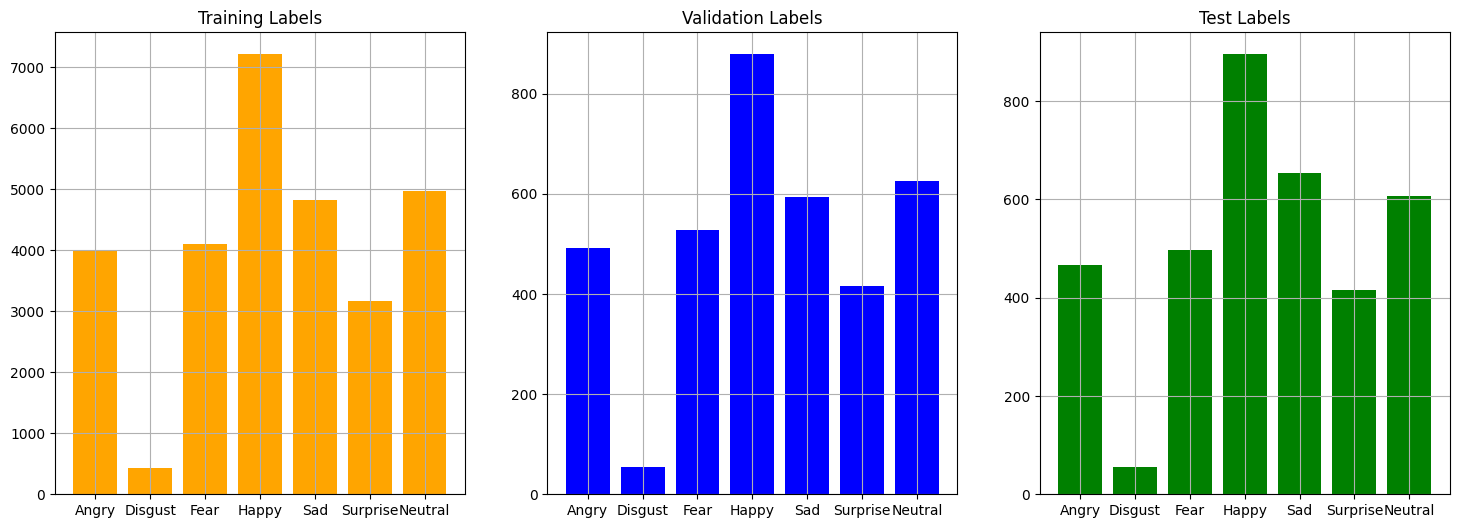

In [ ]:
arrays = [train_labels, val_labels, test_labels]
colors = ["orange", "blue", "green"]
titles = ["Training Labels", "Validation Labels", "Test Labels"]
plot_distributions(arrays, colors, titles)
plt.show()

**Model Training**

In [ ]:
from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

# Initialize a sequential model
model = models.Sequential()

# Add the first convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))

# Add a max-pooling layer
model.add(MaxPool2D((2, 2)))

# Add the second convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another max-pooling layer
model.add(MaxPool2D((2, 2)))

# Add the third convolutional layer
model.add(Conv2D(64, (3, 3), activation='relu'))

# Flatten the output from convolutional layers
model.add(Flatten())

# Add a fully connected layer with ReLU activation
model.add(Dense(64, activation='relu'))

# Add the output layer for multi-class classification
model.add(Dense(7, activation='softmax'))

In [ ]:
# Compile the model with the Adam optimizer, categorical cross-entropy loss, and accuracy metric.
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Display a summary of the CNN model's architecture.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 4096)             

In [ ]:
# Train the CNN model using the training data and validate it with the validation data.
# The model is trained for a specified number of epochs.
# Class weights are used to handle imbalanced datasets.

history = model.fit(
    train_images, train_labels,  # Training data and labels
    validation_data=(val_images, val_labels),  # Validation data for evaluating model performance
    class_weight=class_weight,  # Class weights for handling imbalanced data
    epochs=12,  # Number of training epochs
    batch_size=64  # Number of samples used in each training iteration
)

Epoch 1/12
449/449 [==============================] - 89s 194ms/step - loss: 0.2657 - accuracy: 0.3250 - val_loss: 1.5859 - val_accuracy: 0.3840
Epoch 2/12
449/449 [==============================] - 83s 186ms/step - loss: 0.2290 - accuracy: 0.4307 - val_loss: 1.4753 - val_accuracy: 0.4519
Epoch 3/12
449/449 [==============================] - 86s 192ms/step - loss: 0.2096 - accuracy: 0.4805 - val_loss: 1.3486 - val_accuracy: 0.4968
Epoch 4/12
449/449 [==============================] - 83s 186ms/step - loss: 0.1969 - accuracy: 0.5115 - val_loss: 1.3032 - val_accuracy: 0.5199
Epoch 5/12
449/449 [==============================] - 84s 186ms/step - loss: 0.1875 - accuracy: 0.5392 - val_loss: 1.2815 - val_accuracy: 0.5241
Epoch 6/12
449/449 [==============================] - 91s 203ms/step - loss: 0.1781 - accuracy: 0.5636 - val_loss: 1.3083 - val_accuracy: 0.5210
Epoch 7/12
449/449 [==============================] - 89s 197ms/step - loss: 0.1689 - accuracy: 0.5840 - val_loss: 1.3246 - val_ac

**Model Evaluation**

In [ ]:
# Evaluate the model on the test dataset and get test loss and accuracy
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

# Predict the labels for test images
pred_test_labels  = model.predict(test_images)

# Print the test accuracy
print('Test accuracy:', test_accuracy)
print('Test loss:', test_loss)

113/113 [==============================] - 3s 24ms/step
Test accuracy: 0.5358038544654846
Test loss: 1.4250788688659668


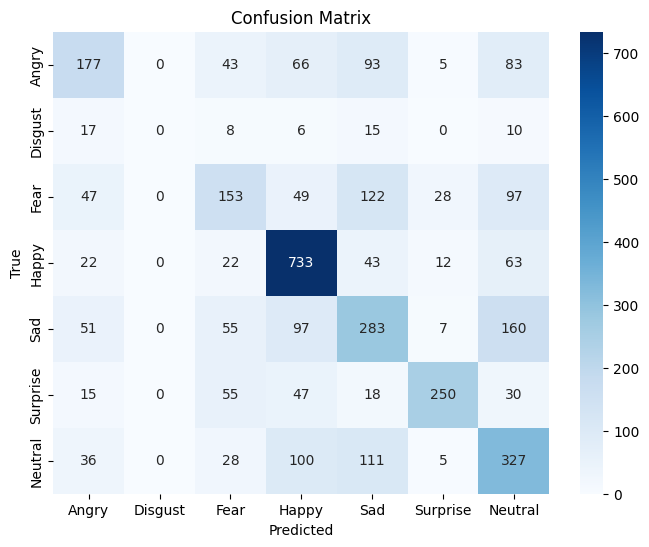

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get the true labels from the test dataset
true_labels = test_image_label

# Get the predicted labels from the model's predictions
predicted_labels = np.argmax(pred_test_labels , axis=1)

# Create the confusion matrix
matrix = confusion_matrix(true_labels, predicted_labels)

# Define emotion labels for visualization
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=emotion_labels, yticklabels=emotion_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

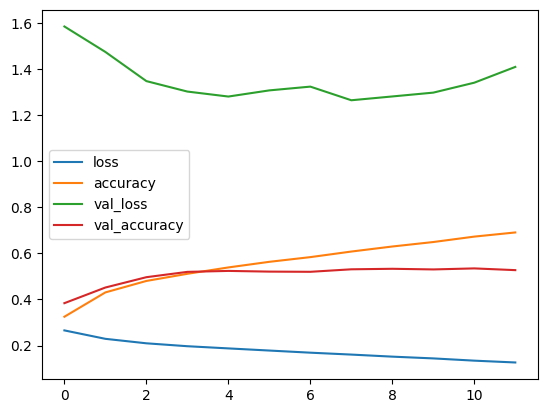

In [ ]:
# Plotting training history for various metrics
for key in history.history.keys():
    # Loop through available metrics
    plt.plot(history.history[key], label=key)  # Plot the metric values
plt.legend()  # Add a legend to the plot

**Model Prediction**


    Function to plot the image and compare the prediction results with the label.
    
    Parameters:
    test_image_array (numpy array): Array of test images.
    test_image_label (numpy array): Array of true emotion labels.
    pred_test_labels (numpy array): Array of predicted emotion labels.
    image_number (int): Index of the image to be displayed.


In [ ]:
def plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, image_number):

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)

    # Define the labels for the bar chart
    bar_label = emotions.values()

    # Plot the test image in the left subplot
    axs[0].imshow(test_image_array[image_number], 'gray')
    axs[0].set_title(emotions[test_image_label[image_number]])

    # Plot the predicted emotion labels as a bar chart in the right subplot
    axs[1].bar(bar_label, pred_test_labels[image_number], color='orange', alpha=0.7)
    axs[1].grid()

    # Show the figure
    plt.show()

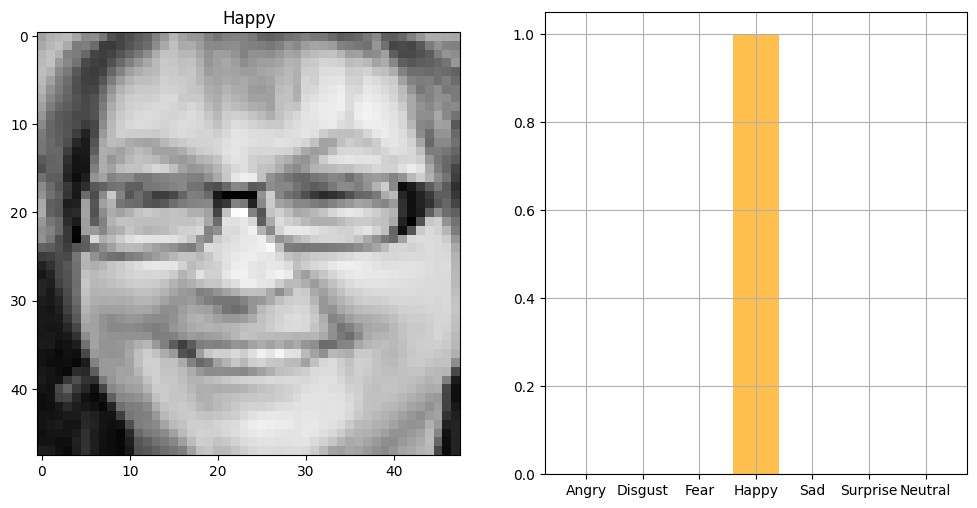

In [ ]:
# Plot and compare the true emotion label and predicted emotion labels for the 100th test image
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 100)

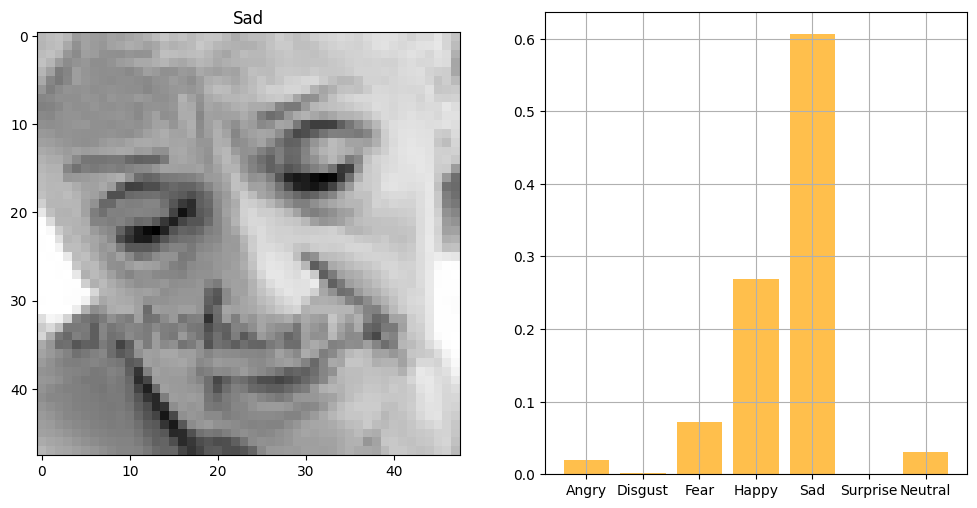

In [ ]:
# Plot and compare the true emotion label and predicted emotion labels for the 600th test image
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 600)

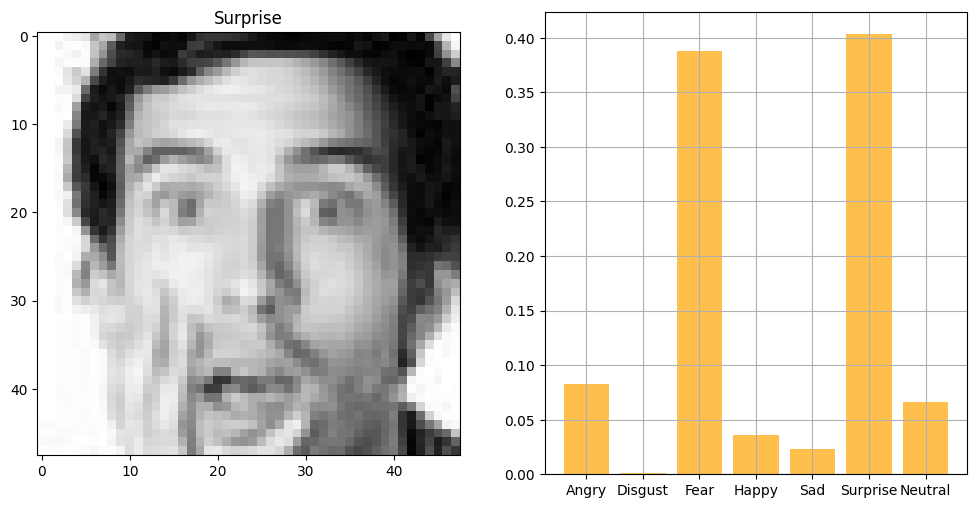

In [ ]:
# Plot and compare the true emotion label and predicted emotion labels for the 1200th test image
plot_image_and_emotion(test_image_array, test_image_label, pred_test_labels, 1200)